In [1]:
%matplotlib inline
from astropy.io import fits as pf
from astroML.correlation import two_point, bootstrap_two_point
import numpy as np
from matplotlib import *
from pylab import *
import pylab as plt
from time import time
from scipy.optimize import curve_fit
from scipy import integrate, constants
import camb
from scipy import interpolate
from scipy.optimize import fsolve
from camb import model


In [2]:
##########################
###Open data set
##########################

infile = '../Xis_Candidates_goodh.txt'

data = open(infile,'rw')

header=data.readline()

sep=[]
xifull=[]
sigma=[]
RR=[]
DD=[]
dat=data.readlines()
for i in range(len(dat)):
    sep.append(float(dat[i].split()[0]))
    xifull.append(float(dat[i].split()[4]))
    sigma.append(float(dat[i].split()[5]))
    RR.append(float(dat[i].split()[3]))
    DD.append(float(dat[i].split()[1]))
#Calculate Poisson error

Poisson_err = (1+np.array(xifull))/np.sqrt(1.0*np.array(DD))

LS_err = (1+np.array(xifull))/np.sqrt(4996.0)

print 'Poisson Errors calculated'

Poisson Errors calculated


In [3]:
#Fit a power law
def Pow_Model(r,s,d):
    xi = (r/s)**(-d)
    return xi

#def Model(r,s):
#    xi = (r/s)**(-2)
#    return xi

Rad = np.asarray(sep)
gdx = (Rad>8) & (Rad<50)
popt, pcov = curve_fit(Pow_Model,Rad[gdx],np.asarray(xifull)[gdx],sigma=np.asarray(sigma)[gdx])
print popt

[ 3.63678787  1.90633663]


In [4]:
#Eftekharzadeh 2015 points

Exi = [2.556,1.663,2.406,1.654,1.020,1.034,0.676,0.562,0.433,0.291,0.193,0.150,0.090,0.069,0.040,0.020,0.010,0.000,0.004]
Es  = [3.06,3.70,4.48,5.41,6.55,7.92,9.59,11.60,14.03,16.97,20.54,24.84,30.06,36.37,43.10,53.23,64.40,77.92,94.27]
Eerr= [0.609,0.384,0.318,0.213,0.132,0.101,0.069,0.050,0.036,0.026,0.018,0.014,0.010,0.007,0.006,0.004,0.003,0.002,0.002]

## Fit a DM model

In [5]:
#I have to find what CAMB thinks sigma 8 is for my cosmology, then I can change it to 0.8
# Print the parameters out
pars2 = camb.CAMBparams()

#Not non-linear corrections couples to smaller scales than you want
pars2.set_matter_power(redshifts=[0., 2.434, 3.479], kmax=10.0)
H = 70 #H0. 
oc = 0.229 #density parameter of CDM 
ob = 0.046 #density parameter of baryons

#H0 is hubble parameter at z=0, ombh2 is the baryon density (physical), omch2 is the matter density (physical)
#mnu is sum of neutrino masses, omk is curvature parameter (set to 0 for flat), meffsterile is effective mass of sterile neutrinos
#pars.set_cosmology(H0=H,ombh2=ob, omch2=oc,omk=0)#,mnu=0,meffsterile=0) 

pars2.H0=H
pars2.omegab=ob
pars2.omegac=oc
pars2.omegav=0.725
pars2.set_dark_energy()

#Set parameters using standard power law parameterization.If nt=None, uses inflation consistency relation.
#As = comoving curvature power (links to sigma8); ns is scalar speectral index
pars2.InitPower.set_params(As = 2e-9,ns=0.960)
#Non-Linear spectra (Halofit)
pars2.NonLinear = model.NonLinear_both
camb.set_halofit_version(version='original') #uses the Smith 2003 halo model
camb.get_transfer_functions(pars2)

results = camb.get_results(pars2)
results.calc_power_spectra(pars2)
kh_nonlin, z_nonlin, pk_nonlin = results.get_matter_power_spectrum(minkh=1e-4, maxkh=10, npoints = 1000)
s82 = np.array(results.get_sigma8())

print results.get_matter_transfer_data()


print s82
print ''

print z_nonlin
print np.shape(pk_nonlin)
print np.shape(kh_nonlin)


Note: redshifts have been re-sorted (earliest first)
[ 0.22504707  0.29163237  0.77303182]

[0.0, 2.434, 3.479]
(3, 1000)
(1000,)


## With sigma8, I can now write the interpolator, changing to sigma8 = 0.8


In [79]:
# Compute the matter power spectrum from CAMB and Generate the P(z,k) function to output the power at any given redshift
#and wavenumber

#First define Planck 2015 cosmological parameters
H = 70 #H0. 
oc = 0.229 #physical density of CDM 
ob = 0.046 #physical density of baryons

#Conversion to density param: Omega_Matter = (oc+ob)/(H0/100.)**2

#Set up parameters in CAMB
pars = camb.CAMBparams()
#H0 is hubble parameter at z=0, ombh2 is the baryon density (physical), omch2 is the matter density (physical)
#mnu is sum of neutrino masses, omk is curvature parameter (set to 0 for flat), meffsterile is effective mass of sterile neutrinos
#pars.set_cosmology(H0=H,ombh2=ob, omch2=oc,omk=0)#,mnu=0,meffsterile=0) 

#Hard code the cosmolgy params
pars.H0=H #hubble param (No h!!)
pars.omegab=ob #Baryon density parameter
pars.omegac=oc #CDM density parameter
pars.omegav=0.725 #Vacuum density parameter
pars.set_dark_energy()

#Set parameters using standard power law parameterization.If nt=None, uses inflation consistency relation.
#ns is scalar spectral index
sig8old = float(s82[-1])
print sig8old

pars.InitPower.set_params(As = 2e-9*(0.8/sig8old)**2,ns=0.960)
camb.set_halofit_version(version='original') #uses the Smith 2003 halo model
ze=np.linspace(0,20,150)
ka=np.logspace(-4,3,1000)#np.linspace(0,10,100)
#Get the matter power spectrum interpolation object (based on RectBivariateSpline). 
#pars: input parameters, zs: redshift range, nonlinear: generate nonlinear power spectrum, hubble_units=True: output as Mpc/h^3 
#instead of Mpc^3 
PK = camb.get_matter_power_interpolator(pars,zs = ze,zmax = ze[-1], nonlinear=True, hubble_units=True, k_hunit=True, kmax = ka[-1])
#Generate the power using the interpolator and the z and k arrays
#Power = PK.P(z,k)

0.773031823703


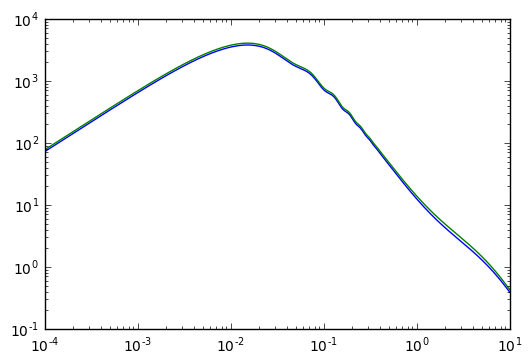

In [80]:
#Test the power spectra
plt.figure(1)
plt.plot(kh_nonlin,pk_nonlin[1])
plt.plot(kh_nonlin,PK.P(2.434,kh_nonlin))
plt.xscale('log')
plt.yscale('log')
plt.show()

In [85]:
#Fit as usual
def dimpower(Pk,z,k):
    delta = Pk.P(z,k) * k**3/(2*np.pi**2)
    return delta

#Fitting routine for BOSS data
def FTint(k,r,z):
    integrand = dimpower(PK,z,10**k)/(10**k) * np.sin(10**k*10**r)/10**r*np.log(10)
    return integrand


#radii = Es
radii = np.linspace(0,2,100)

l = np.linspace(-3,3,500)
Exir = []
for i in range(len(radii)):
    xire = integrate.quad(FTint, min(l), max(l), args=(radii[i],2.434)) #quad(f(x),xlower,xupper, args)

    Exir.append(xire[0])

EXIR = interpolate.interp1d(10**radii,Exir)



def Kz(xir,b):
    z = 2.434
    Om0 = 0.274
    Ol0 = 0.726
    Omz = (Om0*(1+z)**3)/(Om0*(1+z)**3+Ol0)
    f = Omz**0.56
    
    xisk = (b**2 + 2*b*f/3.0 + f**2/5.0)*xir
    return xisk

gdx = (np.asarray(Es)>4) & (np.asarray(Es)<22)
popt2, pcov2 = curve_fit(Kz,EXIR(Es)[gdx],np.asarray(Exi)[gdx],sigma=np.asarray(Eerr)[gdx])

print popt2


[ 3.18783963]


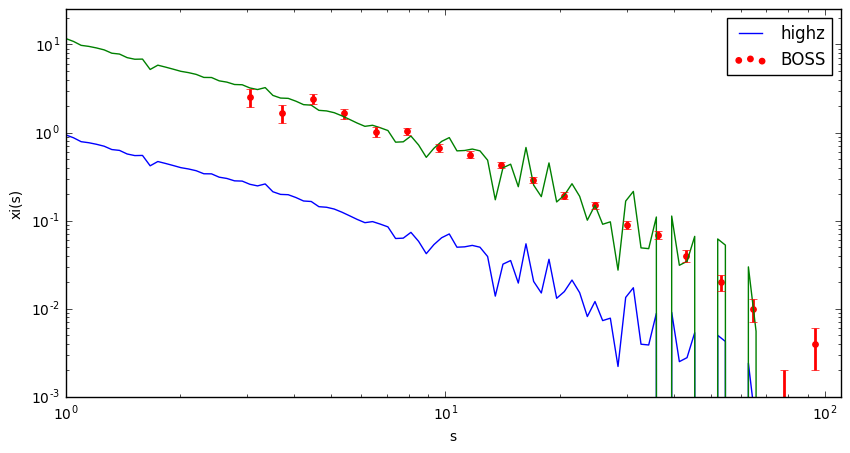

In [86]:
plt.figure(figsize = (10,5))
plt.plot(10**radii,EXIR(10**radii),label='highz')
plt.plot(10**radii,Kz(EXIR(10**radii),popt2))
#plt.scatter(radii,xifull,s=80,color='#32CD32',label='highz')
#plt.errorbar(radii,xifull,yerr=sigma,linestyle="None",linewidth=2,color='#32CD32')
plt.scatter(Es,Exi,s=15,color='r',label='BOSS')
plt.errorbar(Es,Exi,yerr=Eerr,linestyle="None",linewidth=2,color='r')
plt.xlabel('s')
plt.ylabel('xi(s)')
plt.xscale('log')
plt.yscale('log')
ylim(10**-3,25)
xlim(1,110)
plt.legend()
plt.show()

In [10]:
def dimpower(Pk,z,k):
    delta = Pk.P(z,k/0.7) * k**3/(2*np.pi**2)/0.7**3
    return delta

#Fitting routine for Candidates 
def FTint(k,r,z):
    integrand = dimpower(PK,z,k)/k**2 * np.sin(k*r)/r
    return integrand


radii = sep
l = np.exp(np.log(10)*np.linspace(-4,1,1000))

Sxir = []
for i in range(len(radii)):
    xirs = integrate.quad(FTint, min(l), max(l), args=(radii[i],3.479)) #quad(f(x),xlower,xupper, args)
    Sxir.append(xirs[0])


def Kz(xir,b):
    z = 3.479
    Om0 = 0.274
    Ol0 = 0.726
    Omz = (Om0*(1+z)**3)/(Om0*(1+z)**3+Ol0)
    f = Omz**0.56
    
    xisk = (b**2 + 2*b*f/3.0 + f**2/5.0)*xir
    return xisk


gdx = (np.asarray(sep)>8) & (np.asarray(sep)<50)&(np.asarray(xifull)>0)

popt2, pcov2 = curve_fit(Kz,np.asarray(Sxir)[gdx],np.asarray(xifull)[gdx],sigma=np.asarray(sigma)[gdx],absolute_sigma=True)

print popt2
print pcov2

[ 1.29942558]
[[ 0.05330354]]


/Users/johntimlin/anaconda/lib/python2.7/site-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)


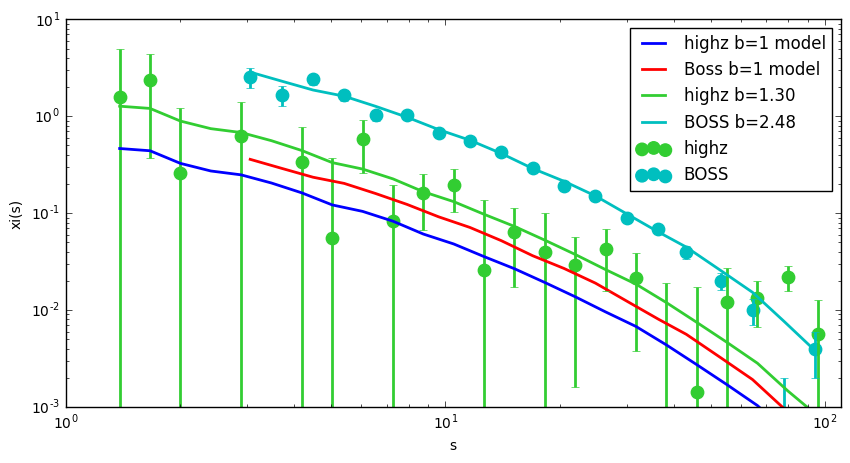

In [11]:
plt.figure(figsize = (10,5))
plt.plot(np.asarray(sep),Sxir,linewidth = 2,label='highz b=1 model')
plt.plot(Es,Exir,color = 'r',linewidth = 2,label='Boss b=1 model')

plt.plot(np.asarray(sep),Kz(np.asarray(Sxir),popt2),color='#32CD32',linewidth = 2,label='highz b=%0.2f'%popt2)
plt.plot(Es,Kz(np.asarray(Exir),popt),color='c',linewidth = 2,label = 'BOSS b=%0.2f'%popt)

plt.scatter(np.asarray(sep),xifull,s=80,color='#32CD32',label='highz')
plt.errorbar(np.asarray(sep),xifull,yerr=sigma,linestyle="None",linewidth=2,color='#32CD32')

plt.scatter(Es,Exi,s=80,color='c',label='BOSS')
plt.errorbar(Es,Exi,yerr=Eerr,linestyle="None",linewidth=2,color='c')
plt.xlabel('s')
plt.ylabel('xi(s)')
plt.xscale('log')
plt.yscale('log')
ylim(10**-3,10)
xlim(1,110)
plt.legend()
plt.show()